## Libraries 

In [668]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
from pprint import pprint
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import folium
from folium.features import DivIcon
import json
import re

## Webcrawl with BeautifulSoup

In [669]:
url='https://www.worldometers.info/coronavirus/'
weburl=requests.get(url).content
soup=BeautifulSoup(weburl,'lxml')

In [670]:
my_table=soup.find('table',id='main_table_countries')
titles=[col.text for col in my_table.find('thead').find_all('th')]
titles[0]='Country'
data=[]
allrows=rows=my_table.find('tbody').find_all({'tr':'row'})
for row in allrows:
    stats=[col.text for col in row.find_all('td')]
    data.append(stats)
    
df=pd.DataFrame(data,columns=titles)
df['Country']=df['Country'].str.strip()
df.reset_index(drop=True).head()

,Country,TotalCases,NewCases,TotalDeaths,NewDeaths,TotalRecovered,ActiveCases,"Serious,Critical",Tot Cases/1M pop
0,China,"80,894",+13,"3,237",+11,"69,614","8,043","2,622",56
1,Italy,"31,506",,"2,503",,"2,941","26,062","2,060",521
2,Iran,"17,361","+1,192","1,135",+147,"5,389","10,837",,207
3,Spain,"13,910","+2,084",623,+90,"1,081","12,206",563,298
4,Germany,"10,082",+715,27,+1,73,"9,982",2,120


In [671]:
def FindCountry(country):
    return(df.loc[df['Country'].str.strip()==country])

In [672]:
def clean_table(col):
    df[col]=df[col].astype(str).str.strip().str.replace('+','').str.replace(',','')
    df[col] = pd.to_numeric(df[col]).fillna(0)
    return df

## Cleaning the Table

In [673]:
colz=df.columns.drop('Country')

for c in colz:
    clean_table(c)

In [674]:
df.columns=['Country','TotalCases','NewCases','TotalDeaths','NewDeaths','TotalRecovered','ActiveCases','Serious','TotalCasesPer1M']

### Adding Additional Statistics

In [675]:
df['Mortality_Rate']=(df['TotalDeaths']/df['TotalCases'])*100
df['Recovery_Rate']=(df['TotalRecovered']/df['TotalCases'])*100
df['Active_Rate']=(df['ActiveCases']/df['TotalCases'])*100
df['MortalityPer1M']=df['Mortality_Rate']*df['TotalCasesPer1M']/100
df['RecoveryPer1M']=df['Recovery_Rate']*df['TotalCasesPer1M']/100
df['Recovery_to_Mortality_Ratio']=df['Recovery_Rate'] / df['Mortality_Rate']
df['Recovery_Odds']=df['Recovery_to_Mortality_Ratio']/(1+df['Recovery_to_Mortality_Ratio'])*100

World_Mortality=df['TotalDeaths'].sum()/df['TotalCases'].sum()
World_Recovery=df['TotalRecovered'].sum()/df['TotalCases'].sum()
World_Active=df['ActiveCases'].sum()/df['TotalCases'].sum()

print('Based on the current information:\n')
print('Total World Mortality Rate: {:0.2%}\nTotal World Recovery Rate: {:0.2%}\nTotal World Active Rate: {:0.2%}'.format(World_Mortality,World_Recovery,World_Active))
print('\n')
print("The Recovery to Mortality Ratio is {:0.1f}.".format(World_Recovery/World_Mortality))

print("This means that for every 1 mortality, {:0.1f} will recover.".format(World_Recovery/World_Mortality))

oddsforsurvival = World_Recovery/(World_Mortality+World_Active)

print("A Patient\'s odds for survival is {:0.2%}".format((oddsforsurvival)))
                                                        
                                                        

Based on the current information:

Total World Mortality Rate: 4.04%
Total World Recovery Rate: 40.48%
Total World Active Rate: 55.48%


The Recovery to Mortality Ratio is 10.0.
This means that for every 1 mortality, 10.0 will recover.
A Patient's odds for survival is 68.01%


In [676]:
df=df
df.head()

,Country,TotalCases,NewCases,TotalDeaths,NewDeaths,TotalRecovered,ActiveCases,Serious,TotalCasesPer1M,Mortality_Rate,Recovery_Rate,Active_Rate,MortalityPer1M,RecoveryPer1M,Recovery_to_Mortality_Ratio,Recovery_Odds
0,China,80894,13.0,3237.0,11.0,69614.0,8043,2622.0,56.0,4.001533,86.055826,9.942641,2.240858,48.191263,21.505715,95.556684
1,Italy,31506,0.0,2503.0,0.0,2941.0,26062,2060.0,521.0,7.944519,9.334730,82.720752,41.390941,48.633943,1.174990,54.022777
2,Iran,17361,1192.0,1135.0,147.0,5389.0,10837,0.0,207.0,6.537642,31.040839,62.421519,13.532919,64.254536,4.748018,82.602698
3,Spain,13910,2084.0,623.0,90.0,1081.0,12206,563.0,298.0,4.478792,7.771387,87.749820,13.346801,23.158735,1.735152,63.438967
4,Germany,10082,715.0,27.0,1.0,73.0,9982,2.0,120.0,0.267804,0.724063,99.008133,0.321365,0.868875,2.703704,73.000000


### Removing entries with less than 50 Total Cases

In [677]:
df=df.sort_values(by=['TotalCases'], ascending=True)
df=df.reset_index()
df.drop(['index'],axis=1)

,Country,TotalCases,NewCases,TotalDeaths,NewDeaths,TotalRecovered,ActiveCases,Serious,TotalCasesPer1M,Mortality_Rate,Recovery_Rate,Active_Rate,MortalityPer1M,RecoveryPer1M,Recovery_to_Mortality_Ratio,Recovery_Odds
0,Togo,1,0.0,0.0,0.0,0.0,1,0.0,0.10,0.000000,0.000000,100.000000,0.000000,0.000000,NaN,NaN
1,Cayman Islands,1,0.0,1.0,0.0,0.0,0,0.0,15.00,100.000000,0.000000,0.000000,15.000000,0.000000,0.000000,0.000000
2,Nepal,1,0.0,0.0,0.0,1.0,0,0.0,0.03,0.000000,100.000000,0.000000,0.000000,0.030000,inf,NaN
3,Antigua and Barbuda,1,0.0,0.0,0.0,0.0,1,0.0,10.00,0.000000,0.000000,100.000000,0.000000,0.000000,NaN,NaN
4,Bahamas,1,0.0,0.0,0.0,0.0,1,0.0,3.00,0.000000,0.000000,100.000000,0.000000,0.000000,NaN,NaN
5,Benin,1,0.0,0.0,0.0,0.0,1,0.0,0.08,0.000000,0.000000,100.000000,0.000000,0.000000,NaN,NaN
6,Bhutan,1,0.0,0.0,0.0,0.0,1,0.0,1.00,0.000000,0.000000,100.000000,0.000000,0.000000,NaN,NaN
7,CAR,1,0.0,0.0,0.0,0.0,1,0.0,0.20,0.000000,0.000000,100.000000,0.000000,0.000000,NaN,NaN
8,Congo,1,0.0,0.0,0.0,0.0,1,0.0,0.20,0.000000,0.000000,100.000000,0.000000,0.000000,NaN,NaN
9,Djibouti,1,1.0,0.0,0.0,0.0,1,0.0,1.00,0.000000,0.000000,100.000000,0.000000,0.000000,NaN,NaN


In [678]:
df=df.loc[77:]
df

,index,Country,TotalCases,NewCases,TotalDeaths,NewDeaths,TotalRecovered,ActiveCases,Serious,TotalCasesPer1M,Mortality_Rate,Recovery_Rate,Active_Rate,MortalityPer1M,RecoveryPer1M,Recovery_to_Mortality_Ratio,Recovery_Odds
77,93,Moldova,30,0.0,1.0,1.0,1.0,28,2.0,7.0,3.333333,3.333333,93.333333,0.233333,0.233333,1.000000,50.000000
78,92,Senegal,31,4.0,0.0,0.0,2.0,29,0.0,2.0,0.000000,6.451613,93.548387,0.000000,0.129032,inf,NaN
79,91,Oman,33,0.0,0.0,0.0,12.0,21,0.0,6.0,0.000000,36.363636,63.636364,0.000000,2.181818,inf,NaN
80,90,Lithuania,33,7.0,0.0,0.0,1.0,32,1.0,12.0,0.000000,3.030303,96.969697,0.000000,0.363636,inf,NaN
81,89,Azerbaijan,34,0.0,1.0,0.0,6.0,27,0.0,3.0,2.941176,17.647059,79.411765,0.088235,0.529412,6.000000,85.714286
82,88,North Macedonia,35,4.0,0.0,0.0,1.0,34,1.0,17.0,0.000000,2.857143,97.142857,0.000000,0.485714,inf,NaN
83,87,Cambodia,35,2.0,0.0,0.0,1.0,34,0.0,2.0,0.000000,2.857143,97.142857,0.000000,0.057143,inf,NaN
84,86,Venezuela,36,3.0,0.0,0.0,0.0,36,0.0,1.0,0.000000,0.000000,100.000000,0.000000,0.000000,NaN,NaN
85,85,Kazakhstan,36,3.0,0.0,0.0,0.0,36,0.0,2.0,0.000000,0.000000,100.000000,0.000000,0.000000,NaN,NaN
86,83,Georgia,38,4.0,0.0,0.0,1.0,37,1.0,10.0,0.000000,2.631579,97.368421,0.000000,0.263158,inf,NaN


## Final Table

In [679]:
df.head()

,index,Country,TotalCases,NewCases,TotalDeaths,NewDeaths,TotalRecovered,ActiveCases,Serious,TotalCasesPer1M,Mortality_Rate,Recovery_Rate,Active_Rate,MortalityPer1M,RecoveryPer1M,Recovery_to_Mortality_Ratio,Recovery_Odds
77,93,Moldova,30,0.0,1.0,1.0,1.0,28,2.0,7.0,3.333333,3.333333,93.333333,0.233333,0.233333,1.0,50.000000
78,92,Senegal,31,4.0,0.0,0.0,2.0,29,0.0,2.0,0.000000,6.451613,93.548387,0.000000,0.129032,inf,NaN
79,91,Oman,33,0.0,0.0,0.0,12.0,21,0.0,6.0,0.000000,36.363636,63.636364,0.000000,2.181818,inf,NaN
80,90,Lithuania,33,7.0,0.0,0.0,1.0,32,1.0,12.0,0.000000,3.030303,96.969697,0.000000,0.363636,inf,NaN
81,89,Azerbaijan,34,0.0,1.0,0.0,6.0,27,0.0,3.0,2.941176,17.647059,79.411765,0.088235,0.529412,6.0,85.714286


In [680]:
df.sort_values(by=['MortalityPer1M'], ascending=False).head(5)
df[df['Country']=='Singapore']

,index,Country,TotalCases,NewCases,TotalDeaths,NewDeaths,TotalRecovered,ActiveCases,Serious,TotalCasesPer1M,Mortality_Rate,Recovery_Rate,Active_Rate,MortalityPer1M,RecoveryPer1M,Recovery_to_Mortality_Ratio,Recovery_Odds
142,28,Singapore,313,47.0,0.0,0.0,114.0,199,14.0,54.0,0.0,36.421725,63.578275,0.0,19.667732,inf,NaN


## Looking at the Top Cases

### - Top Cases

In [681]:
df.head()

,index,Country,TotalCases,NewCases,TotalDeaths,NewDeaths,TotalRecovered,ActiveCases,Serious,TotalCasesPer1M,Mortality_Rate,Recovery_Rate,Active_Rate,MortalityPer1M,RecoveryPer1M,Recovery_to_Mortality_Ratio,Recovery_Odds
77,93,Moldova,30,0.0,1.0,1.0,1.0,28,2.0,7.0,3.333333,3.333333,93.333333,0.233333,0.233333,1.0,50.000000
78,92,Senegal,31,4.0,0.0,0.0,2.0,29,0.0,2.0,0.000000,6.451613,93.548387,0.000000,0.129032,inf,NaN
79,91,Oman,33,0.0,0.0,0.0,12.0,21,0.0,6.0,0.000000,36.363636,63.636364,0.000000,2.181818,inf,NaN
80,90,Lithuania,33,7.0,0.0,0.0,1.0,32,1.0,12.0,0.000000,3.030303,96.969697,0.000000,0.363636,inf,NaN
81,89,Azerbaijan,34,0.0,1.0,0.0,6.0,27,0.0,3.0,2.941176,17.647059,79.411765,0.088235,0.529412,6.0,85.714286


In [682]:
df=df.sort_values(by=['TotalCases'], ascending=True)
df=df.loc[100:]
df

,index,Country,TotalCases,NewCases,TotalDeaths,NewDeaths,TotalRecovered,ActiveCases,Serious,TotalCasesPer1M,Mortality_Rate,Recovery_Rate,Active_Rate,MortalityPer1M,RecoveryPer1M,Recovery_to_Mortality_Ratio,Recovery_Odds
100,70,Albania,59,4.0,2.0,1.0,0.0,57,2.0,21.0,3.389831,0.000000,96.610169,0.711864,0.000000,0.000000,0.000000
101,69,Brunei,68,12.0,0.0,0.0,0.0,68,2.0,155.0,0.000000,0.000000,100.000000,0.000000,0.000000,NaN,NaN
102,68,Vietnam,68,2.0,0.0,0.0,16.0,52,0.0,0.7,0.000000,23.529412,76.470588,0.000000,0.164706,inf,NaN
103,67,Latvia,71,11.0,0.0,0.0,1.0,70,0.0,38.0,0.000000,1.408451,98.591549,0.000000,0.535211,inf,NaN
104,66,Algeria,72,11.0,6.0,1.0,10.0,56,0.0,2.0,8.333333,13.888889,77.777778,0.166667,0.277778,1.666667,62.500000
105,65,Colombia,75,10.0,0.0,0.0,1.0,74,0.0,1.0,0.000000,1.333333,98.666667,0.000000,0.013333,inf,NaN
106,64,Argentina,79,0.0,2.0,0.0,3.0,74,1.0,2.0,2.531646,3.797468,93.670886,0.050633,0.075949,1.500000,60.000000
107,62,Bulgaria,81,0.0,2.0,0.0,0.0,79,0.0,12.0,2.469136,0.000000,97.530864,0.296296,0.000000,0.000000,0.000000
108,63,Croatia,81,12.0,0.0,0.0,5.0,76,0.0,20.0,0.000000,6.172840,93.827160,0.000000,1.234568,inf,NaN
109,61,Serbia,83,11.0,0.0,0.0,1.0,82,4.0,9.0,0.000000,1.204819,98.795181,0.000000,0.108434,inf,NaN


In [683]:
top=df.sort_values(by=['TotalCases'], ascending=False).head()

In [684]:
colz2=df.columns.drop('Country')
def getOther(col):
    df_other=df[col].sum()-top[col].sum()
    return df_other

In [685]:
def getRatio(percent,mycol):
    df[percent]=df[mycol]/df[mycol].sum()
    top=df.sort_values(by=[mycol],ascending=False)
    return top
top.head()

,index,Country,TotalCases,NewCases,TotalDeaths,NewDeaths,TotalRecovered,ActiveCases,Serious,TotalCasesPer1M,Mortality_Rate,Recovery_Rate,Active_Rate,MortalityPer1M,RecoveryPer1M,Recovery_to_Mortality_Ratio,Recovery_Odds
170,0,China,80894,13.0,3237.0,11.0,69614.0,8043,2622.0,56.0,4.001533,86.055826,9.942641,2.240858,48.191263,21.505715,95.556684
169,1,Italy,31506,0.0,2503.0,0.0,2941.0,26062,2060.0,521.0,7.944519,9.334730,82.720752,41.390941,48.633943,1.174990,54.022777
168,2,Iran,17361,1192.0,1135.0,147.0,5389.0,10837,0.0,207.0,6.537642,31.040839,62.421519,13.532919,64.254536,4.748018,82.602698
167,3,Spain,13910,2084.0,623.0,90.0,1081.0,12206,563.0,298.0,4.478792,7.771387,87.749820,13.346801,23.158735,1.735152,63.438967
166,4,Germany,10082,715.0,27.0,1.0,73.0,9982,2.0,120.0,0.267804,0.724063,99.008133,0.321365,0.868875,2.703704,73.000000


In [686]:
lst=[getOther(c) for c in colz2]
df_other=pd.DataFrame(lst).T
df_other.columns=colz2
df_other['Country']='Other'
top=top.append(df_other)
top=top.reset_index(drop=True)
top['Mortality_Rate']=(top['TotalDeaths']/top['TotalCases'])*100
top['Recovery_Rate']=(top['TotalRecovered']/top['TotalCases'])*100
top['Active_Rate']=(top['ActiveCases']/top['TotalCases'])*100
top['MortalityPer1M']=top['Mortality_Rate']*top['TotalCasesPer1M']/100
top['RecoveryPer1M']=top['Recovery_Rate']*top['TotalCasesPer1M']/100
top['Recovery_to_Mortality_Ratio']=top['Recovery_Rate'] / top['Mortality_Rate']
top['Recovery_Odds']=top['Recovery_to_Mortality_Ratio']/(1+top['Recovery_to_Mortality_Ratio'])*100

top=top.sort_values(by=['Recovery_Odds'],ascending=False)
top

,ActiveCases,Active_Rate,Country,MortalityPer1M,Mortality_Rate,NewCases,NewDeaths,RecoveryPer1M,Recovery_Odds,Recovery_Rate,Recovery_to_Mortality_Ratio,Serious,TotalCases,TotalCasesPer1M,TotalDeaths,TotalRecovered,index
0,8043.0,9.942641,China,2.240858,4.001533,13.0,11.0,48.191263,95.556684,86.055826,21.505715,2622.0,80894.0,56.0,3237.0,69614.0,0.0
5,45046.0,91.031445,Other,114.555594,1.475224,2340.0,51.0,581.879646,83.551149,7.493331,5.079452,1170.0,49484.0,7765.3,730.0,3708.0,2475.0
2,10837.0,62.421519,Iran,13.532919,6.537642,1192.0,147.0,64.254536,82.602698,31.040839,4.748018,0.0,17361.0,207.0,1135.0,5389.0,2.0
4,9982.0,99.008133,Germany,0.321365,0.267804,715.0,1.0,0.868875,73.000000,0.724063,2.703704,2.0,10082.0,120.0,27.0,73.0,4.0
3,12206.0,87.749820,Spain,13.346801,4.478792,2084.0,90.0,23.158735,63.438967,7.771387,1.735152,563.0,13910.0,298.0,623.0,1081.0,3.0
1,26062.0,82.720752,Italy,41.390941,7.944519,0.0,0.0,48.633943,54.022777,9.334730,1.174990,2060.0,31506.0,521.0,2503.0,2941.0,1.0


In [687]:
df_other

,index,TotalCases,NewCases,TotalDeaths,NewDeaths,TotalRecovered,ActiveCases,Serious,TotalCasesPer1M,Mortality_Rate,Recovery_Rate,Active_Rate,MortalityPer1M,RecoveryPer1M,Recovery_to_Mortality_Ratio,Recovery_Odds,Country
0,2475.0,49484.0,2340.0,730.0,51.0,3708.0,45046.0,1170.0,7765.3,93.476122,477.448659,6029.07522,349.906539,287.676988,inf,2077.782117,Other


In [688]:
top.style.background_gradient(cmap='Reds')

,ActiveCases,Active_Rate,Country,MortalityPer1M,Mortality_Rate,NewCases,NewDeaths,RecoveryPer1M,Recovery_Odds,Recovery_Rate,Recovery_to_Mortality_Ratio,Serious,TotalCases,TotalCasesPer1M,TotalDeaths,TotalRecovered,index
0,8043,9.94264,China,2.24086,4.00153,13,11,48.1913,95.5567,86.0558,21.5057,2622,80894,56,3237,69614,0
5,45046,91.0314,Other,114.556,1.47522,2340,51,581.88,83.5511,7.49333,5.07945,1170,49484,7765.3,730,3708,2475
2,10837,62.4215,Iran,13.5329,6.53764,1192,147,64.2545,82.6027,31.0408,4.74802,0,17361,207,1135,5389,2
4,9982,99.0081,Germany,0.321365,0.267804,715,1,0.868875,73,0.724063,2.7037,2,10082,120,27,73,4
3,12206,87.7498,Spain,13.3468,4.47879,2084,90,23.1587,63.439,7.77139,1.73515,563,13910,298,623,1081,3
1,26062,82.7208,Italy,41.3909,7.94452,0,0,48.6339,54.0228,9.33473,1.17499,2060,31506,521,2503,2941,1


### Total Cases

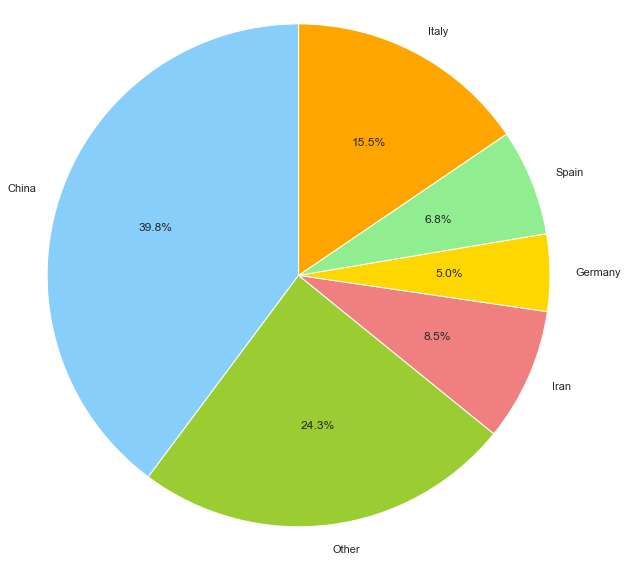

In [689]:
labels=top['Country']
sizes=top['TotalCases']
colors=['lightskyblue','yellowgreen','lightcoral','gold','lightgreen','orange']

plt.pie(x=sizes,labels=labels,colors=colors,autopct='%1.1f%%',shadow=False,startangle=90)
plt.gcf().set_size_inches(10,10)
plt.axis('equal')
plt.show()

### Active Cases

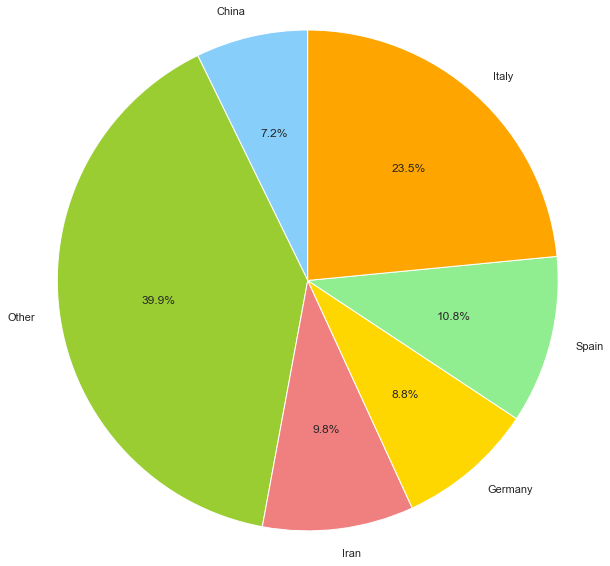

In [543]:
labels=top['Country']
sizes=top['ActiveCases']
colors=['lightskyblue','yellowgreen','lightcoral','gold','lightgreen','orange']

plt.pie(x=sizes,labels=labels,colors=colors,autopct='%1.1f%%',shadow=False,startangle=90)
plt.gcf().set_size_inches(10,10)
plt.axis('equal')
plt.show()

### Recovery Rate Analysis

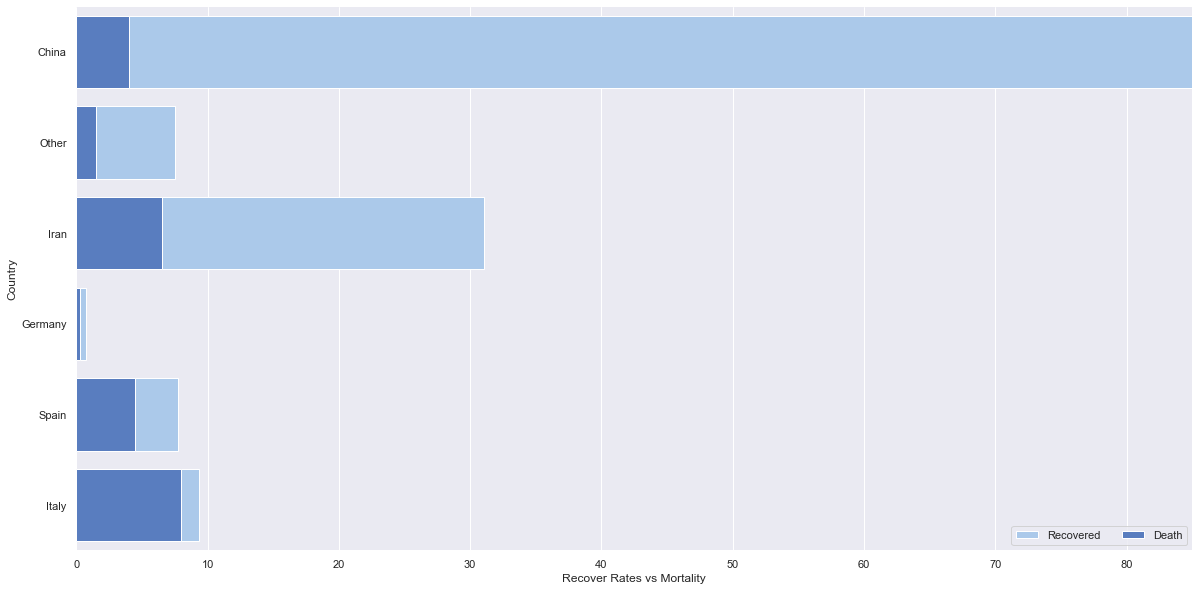

In [690]:
f,ax = plt.subplots(figsize=(20,10))
sns.set_color_codes("pastel")
sns.barplot(x="Recovery_Rate", y="Country",data=top, label='Recovered',color="b")

sns.set_color_codes("muted")
sns.barplot(x="Mortality_Rate", y="Country",data=top, label='Death',color="b")

ax.legend(ncol=2,loc="lower right",frameon=True)
ax.set(xlim=(0,85),ylabel="Country",xlabel="Recover Rates vs Mortality")
sns.despine(left=True, bottom=True)

### Recovery Odds


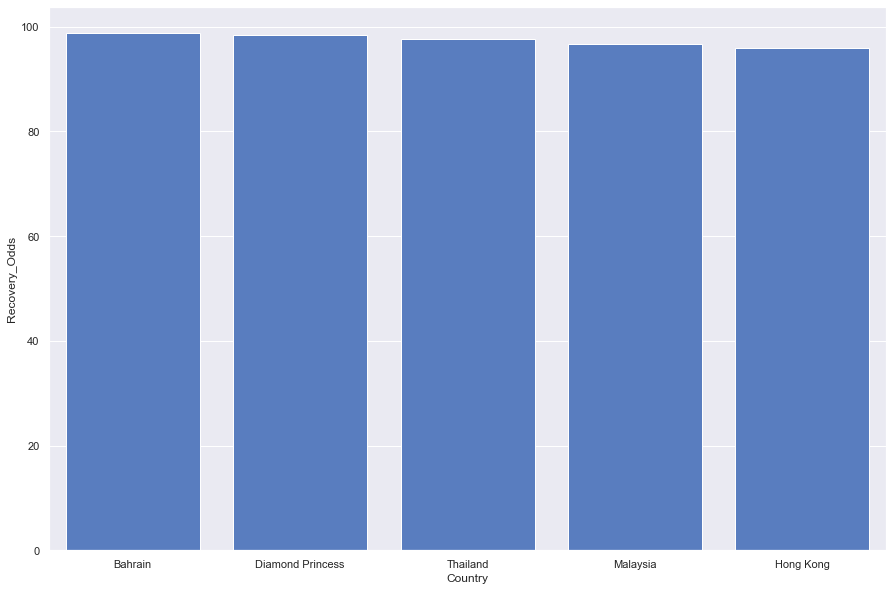

In [691]:
top=df.sort_values(by=['Recovery_Odds'], ascending=False).head()
f,ax = plt.subplots(figsize=(15,10))
ax=sns.barplot(x="Country", y="Recovery_Odds",data=top, label='Recovery Odds',color="b")

## Map

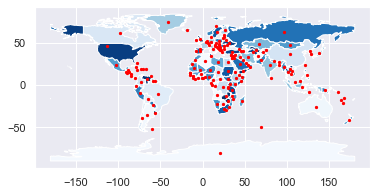

In [692]:
import geopandas as gpd

# Access built-in Natural Earth data via GeoPandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Get a list (dataframe) of country centroids
centroids = world.centroid
centroid_list = pd.concat([world.name, centroids], axis=1)

# Plot the results
base = world.plot(column = 'name', cmap = 'Blues')
centroids.plot(ax = base, marker = 'o', color = 'red', markersize = 5)
centroid_list.columns=['Country','latlng']

In [693]:
df_merged_lng=pd.merge(df,centroid_list,on='Country')
df_merged_lng[df_merged_lng['Country']=='Singapore']

,index,Country,TotalCases,NewCases,TotalDeaths,NewDeaths,TotalRecovered,ActiveCases,Serious,TotalCasesPer1M,Mortality_Rate,Recovery_Rate,Active_Rate,MortalityPer1M,RecoveryPer1M,Recovery_to_Mortality_Ratio,Recovery_Odds,latlng


In [694]:
m = folium.Map(
    location=[35,56],
    zoom_start=2,
)

def getMarkers(df):
    for i in range(len(df)):
        string='Country: {}'.format(df.loc[i]['Country'])
        if df.loc[i]['Recovery_Odds']>75:
            folium.Marker(
            location=((df['latlng'][i]).y,df['latlng'][i].x),
                popup=string,
                color="green",
                icon=folium.Icon(color='green',icon='')).add_to(m)
    
        elif (df.loc[i]['Recovery_Odds']>25 and df.loc[i]['Recovery_Odds']<75):
            folium.Marker(
            location=((df['latlng'][i]).y,df['latlng'][i].x),
                popup=string,
                color="yellow",
                icon=folium.Icon(color='orange',icon='')).add_to(m)

        elif df.loc[i]['Recovery_Odds']<25:
            folium.Marker(
            location=((df['latlng'][i]).y,df['latlng'][i].x),
                popup=string,
                color="green",
                icon=folium.Icon(color='red',icon='')).add_to(m)

getMarkers(df_merged_lng)
m

## Time Series Analysis

### Getting all Recoveries

In [64]:
url2='https://www.worldometers.info/coronavirus/coronavirus-cases/'
weburl2=requests.get(url2).content
soup2 = BeautifulSoup(weburl2,'lxml')
cured = soup2.find('div', id='cured-total').find('script',type='text/javascript').text
cat = re.search(r'{ categories:(.*?) yAxis:',cured).group(1)
categories = re.search(r'(.*?)]',cat).group(1).replace('[','').replace(']','').replace('"','').replace(' ','').split(',')
dta=re.search(r' data:(.*?), responsive:', cured).group(1)
data=re.search(r' (.*?)}]',dta).group(1).replace('[','').replace(']','').replace('"','').replace(' ','').split(',')
final_data =[int(d) for d in data] 
d={
    'Date':categories,
    'Recovery':final_data
}
df_rec=pd.DataFrame(d)

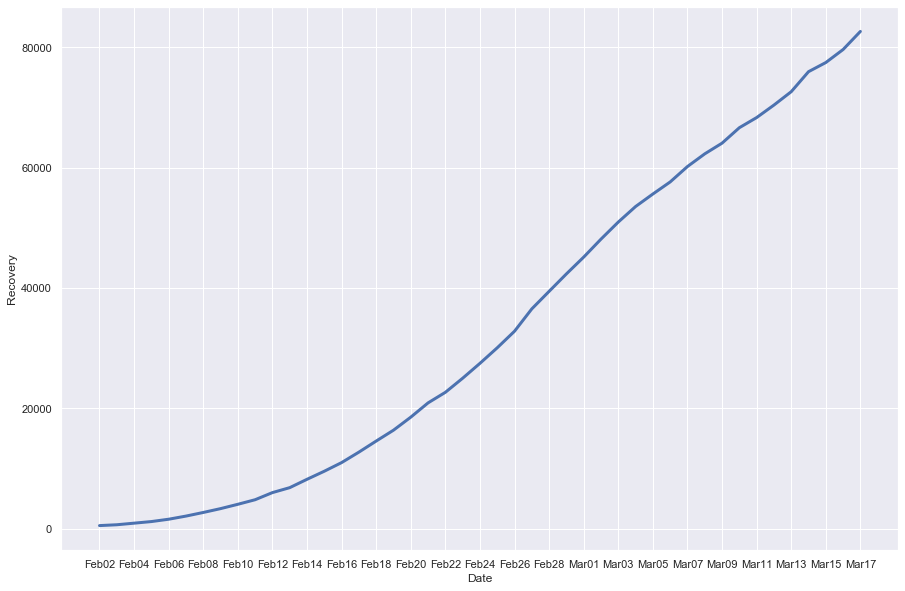

In [65]:
f,ax=plt.subplots(figsize=(15,10))
ax = sns.lineplot(x='Date',y='Recovery',data=df_rec,lw=3)
xticks=ax.xaxis.get_major_ticks()
for i in range(len(xticks)):
    if i%2==1:
        xticks[i].set_visible(False)
        
plt.show()

In [580]:
fig = px.line(df_rec, x="Date", y="Recovery",title='Recovery Over Time')
fig.show()

### Getting all Deaths 

In [184]:
url3='https://www.worldometers.info/coronavirus/coronavirus-death-toll/'
weburl3=requests.get(url3).content
soup3 = BeautifulSoup(weburl3,'lxml')

dead=soup3.find_all('script',type='text/javascript')[9].text

cat3 = re.search(r'{ categories:(.*?) yAxis:',dead).group(1)
categories3 = re.search(r'(.*?)]',cat3).group(1).replace('[','').replace(']','').replace('"','').replace(' ','').split(',')
dta3=re.search(r' data:(.*?), responsive:', dead).group(1)
data3=re.search(r' (.*?)}]',dta3).group(1).replace('[','').replace(']','').replace('"','').replace(' ','').split(',')
final_data3 =[int(d) for d in data3] 
d3={
    'Date':categories3,
    'Dead':final_data3
}
df_dd=pd.DataFrame(d3)



In [67]:
df_dd=df_dd.loc[11:]

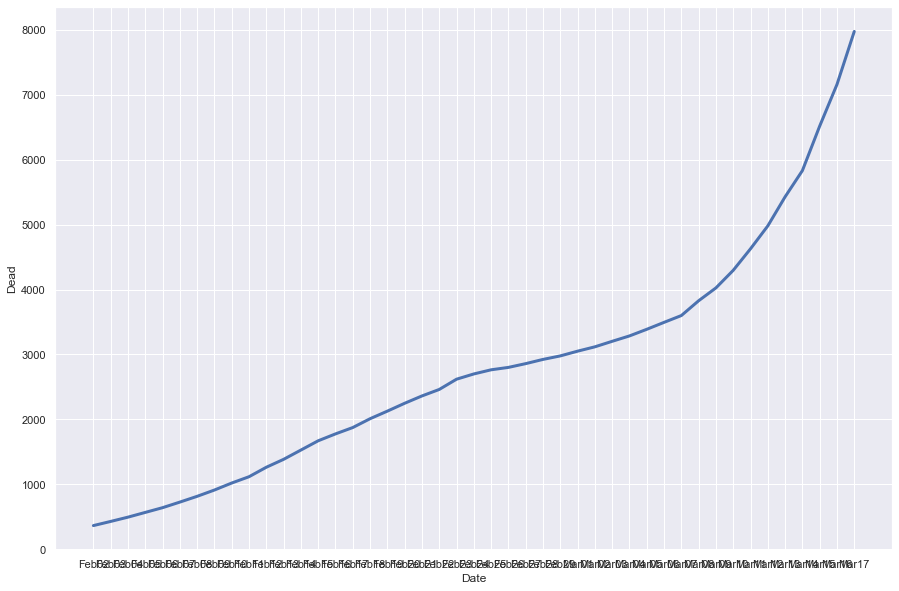

In [68]:
f,ax=plt.subplots(figsize=(15,10))

ax = sns.lineplot(x="Date", y="Dead",data=df_dd, lw=3)

for i in range(len(xticks)):
    if i%2==1:
        xticks[i].set_visible(False)
        
plt.show()

In [581]:
fig = px.line(df_dd, x="Date", y="Dead",title='Recovery Over Time', color_discrete_sequence=[dth, rec])
fig.show()

In [69]:
df_rec_dead=pd.merge(df_rec,df_dd,on='Date')
df_rec_dead['World_Recovery_Odds']=df_rec_dead['Recovery']/(df_rec_dead['Recovery']+df_rec_dead['Dead'])*100
df_rec_dead.head()

,Date,Recovery,Dead,World_Recovery_Odds
0,Feb02,504,362,58.198614
1,Feb03,643,426,60.149673
2,Feb04,907,492,64.832023
3,Feb05,1173,565,67.491369
4,Feb06,1562,638,71.000000


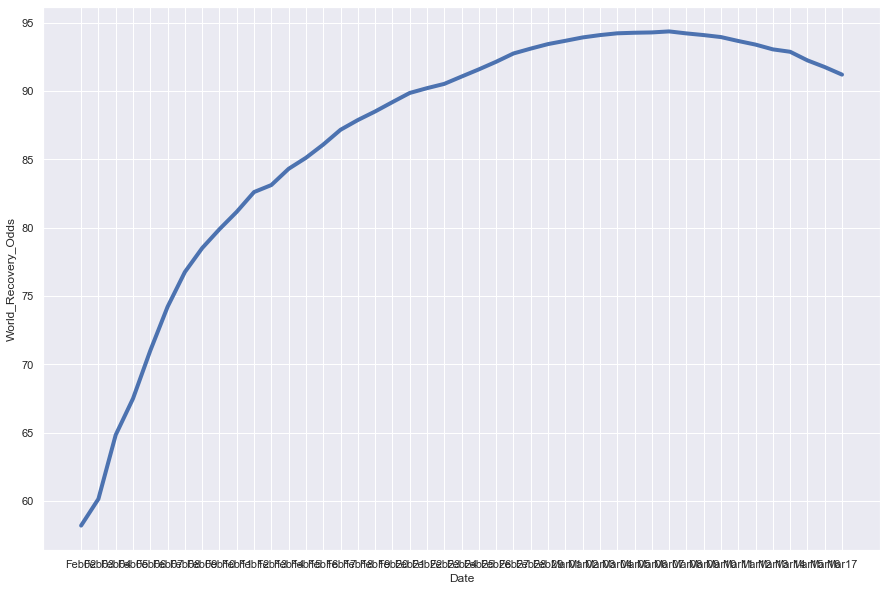

In [70]:
f,ax=plt.subplots(figsize=(15,10))

ax = sns.lineplot(x="Date", y="World_Recovery_Odds",data=df_rec_dead,lw=4)

for i in range(len(xticks)):
    if i%2==1:
        xticks[i].set_visible(False)
        
plt.show()

In [598]:
fig = px.line(df_rec_dead, x="Date", y="World_Recovery_Odds",title='Recovery Over Time')

fig.show()

In [603]:
fig = go.Figure()
# Create and style traces
Date=df_rec_dead['Date']
Dead=df_rec_dead['Dead']
Recover=df_rec_dead['Recovery']
Recover_rate=df_rec_dead['World_Recovery_Odds']
fig.add_trace(go.Scatter(x=Date, y=Dead, name='Dead',
                         line=dict(color='firebrick', width=4)))
fig.add_trace(go.Scatter(x=Date, y=Recover, name='Recover',
                         line=dict(color='firebrick', width=4)))
fig.add_trace(go.Scatter(x=Date, y=Recover_rate, name='Recovery Odds',
                         line=dict(color='firebrick', width=4)))

### Life Expectancy 

In [71]:
df_ages=pd.read_csv('Life Expectancy Data.csv')
df_ages=df_ages[df_ages['Year']==2015]
df_ages=df_ages.drop(['percentage expenditure','Total expenditure','Year','Income composition of resources','Alcohol'],axis=1)

In [72]:
df_age_recovery = pd.merge(df_ages,df, on='Country')
df_age_recovery.sort_values(by=['Country'],ascending=True)

,Country,Status,Life expectancy,Adult Mortality,infant deaths,Hepatitis B,Measles,BMI,under-five deaths,Polio,...,ActiveCases,Serious,TotalCasesPer1M,Mortality_Rate,Recovery_Rate,Active_Rate,MortalityPer1M,RecoveryPer1M,Recovery_to_Mortality_Ratio,Recovery_Odds
0,Afghanistan,Developing,65.0,263.0,62,65.0,1154,19.1,83,6.0,...,21,0.0,0.60,0.000000,4.545455,95.454545,0.000000,0.027273,inf,NaN
1,Albania,Developing,77.8,74.0,0,99.0,0,58.0,0,99.0,...,53,2.0,19.00,3.636364,0.000000,96.363636,0.690909,0.000000,0.000000,0.000000
2,Algeria,Developing,75.6,19.0,21,95.0,63,59.5,24,95.0,...,52,0.0,2.00,7.462687,14.925373,77.611940,0.149254,0.298507,2.000000,66.666667
3,Antigua and Barbuda,Developing,76.4,13.0,0,99.0,0,47.7,0,86.0,...,1,0.0,10.00,0.000000,0.000000,100.000000,0.000000,0.000000,NaN,NaN
4,Argentina,Developing,76.3,116.0,8,94.0,0,62.8,9,93.0,...,74,1.0,2.00,2.531646,3.797468,93.670886,0.050633,0.075949,1.500000,60.000000
5,Armenia,Developing,74.8,118.0,1,94.0,33,54.9,1,96.0,...,83,2.0,28.00,0.000000,1.190476,98.809524,0.000000,0.333333,inf,NaN
6,Australia,Developed,82.8,59.0,1,93.0,74,66.6,1,93.0,...,516,1.0,22.00,1.061947,7.610619,91.327434,0.233628,1.674336,7.166667,87.755102
7,Austria,Developed,81.5,65.0,0,93.0,309,57.6,0,93.0,...,1458,12.0,163.00,0.271924,0.611829,99.116247,0.443236,0.997281,2.250000,69.230769
8,Azerbaijan,Developing,72.7,118.0,5,96.0,0,52.5,6,98.0,...,27,0.0,3.00,2.941176,17.647059,79.411765,0.088235,0.529412,6.000000,85.714286
9,Bahamas,Developing,76.1,147.0,0,95.0,0,64.5,0,95.0,...,1,0.0,3.00,0.000000,0.000000,100.000000,0.000000,0.000000,NaN,NaN


In [73]:
df_age_recovery.corr()

,Life expectancy,Adult Mortality,infant deaths,Hepatitis B,Measles,BMI,under-five deaths,Polio,Diphtheria,HIV/AIDS,...,ActiveCases,Serious,TotalCasesPer1M,Mortality_Rate,Recovery_Rate,Active_Rate,MortalityPer1M,RecoveryPer1M,Recovery_to_Mortality_Ratio,Recovery_Odds
Life expectancy,1.000000,-0.762875,-0.288070,0.376043,-0.152663,0.512173,-0.317613,0.501690,0.472560,-0.621739,...,0.246066,0.137270,0.429312,-0.110717,0.014132,0.050125,0.180685,0.202247,-0.045425,0.130237
Adult Mortality,-0.762875,1.000000,0.250670,-0.255427,0.141314,-0.410518,0.279006,-0.395410,-0.391246,0.514462,...,-0.194038,-0.126389,-0.333272,0.110735,-0.031734,-0.035394,-0.140705,-0.199343,-0.052653,-0.188778
infant deaths,-0.288070,0.250670,1.000000,-0.088469,0.817104,-0.256860,0.994211,-0.164736,-0.136136,0.169982,...,-0.016123,0.067360,-0.100968,0.038101,0.170513,-0.164121,-0.033897,0.011636,0.007498,0.185360
Hepatitis B,0.376043,-0.255427,-0.088469,1.000000,0.011298,0.249957,-0.104939,0.543821,0.863295,-0.397580,...,0.076031,0.079503,0.149909,-0.014745,0.086563,-0.064233,0.059724,0.118519,0.200671,0.289826
Measles,-0.152663,0.141314,0.817104,0.011298,1.000000,-0.188118,0.781631,-0.065607,-0.019992,0.013326,...,0.066299,0.275424,-0.066642,0.034116,0.242235,-0.221955,-0.012821,0.162837,0.058858,0.241840
BMI,0.512173,-0.410518,-0.256860,0.249957,-0.188118,1.000000,-0.264401,0.394981,0.252284,-0.306046,...,0.151224,0.035088,0.256620,0.055535,-0.112950,0.099986,0.128637,0.107834,-0.112993,-0.023067
under-five deaths,-0.317613,0.279006,0.994211,-0.104939,0.781631,-0.264401,1.000000,-0.181653,-0.155315,0.212558,...,-0.020625,0.056750,-0.103279,0.041805,0.175502,-0.170372,-0.034901,0.003610,0.005467,0.180598
Polio,0.501690,-0.395410,-0.164736,0.543821,-0.065607,0.394981,-0.181653,1.000000,0.638646,-0.399683,...,0.097770,0.081068,0.170358,-0.045221,-0.158488,0.158035,0.061182,0.117602,0.153467,0.265024
Diphtheria,0.472560,-0.391246,-0.136136,0.863295,-0.019992,0.252284,-0.155315,0.638646,1.000000,-0.486767,...,0.091731,0.076128,0.160047,-0.038041,0.069956,-0.037297,0.056853,0.111675,0.151534,0.267142
HIV/AIDS,-0.621739,0.514462,0.169982,-0.397580,0.013326,-0.306046,0.212558,-0.399683,-0.486767,1.000000,...,-0.088912,-0.062646,-0.153770,-0.045964,-0.050848,0.068306,-0.060650,-0.094597,-0.131117,-0.369701


In [74]:
df_ages[df_ages['Country']=='Singapore']

,Country,Status,Life expectancy,Adult Mortality,infant deaths,Hepatitis B,Measles,BMI,under-five deaths,Polio,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Schooling
2313,Singapore,Developed,83.1,55.0,0,96.0,0,33.2,0,96.0,96.0,0.1,53629.73746,NaN,2.2,2.2,15.4


In [75]:
df

,Country,TotalCases,NewCases,TotalDeaths,NewDeaths,TotalRecovered,ActiveCases,Serious,TotalCasesPer1M,Mortality_Rate,Recovery_Rate,Active_Rate,MortalityPer1M,RecoveryPer1M,Recovery_to_Mortality_Ratio,Recovery_Odds
0,China,80894,13.0,3237.0,11.0,69614.0,8043,2622.0,56.00,4.001533,86.055826,9.942641,2.240858,48.191263,21.505715,95.556684
1,Italy,31506,0.0,2503.0,0.0,2941.0,26062,2060.0,521.00,7.944519,9.334730,82.720752,41.390941,48.633943,1.174990,54.022777
2,Iran,16169,0.0,988.0,0.0,5389.0,9792,0.0,193.00,6.110458,33.329210,60.560331,11.793184,64.325376,5.454453,84.506821
3,Spain,11826,0.0,533.0,0.0,1028.0,10265,563.0,253.00,4.507018,8.692711,86.800271,11.402757,21.992559,1.928705,65.855221
4,Germany,9414,47.0,26.0,0.0,71.0,9317,2.0,112.00,0.276184,0.754196,98.969620,0.309327,0.844699,2.730769,73.195876
5,S. Korea,8413,93.0,84.0,3.0,1540.0,6789,59.0,164.00,0.998455,18.305004,80.696541,1.637466,30.020207,18.333333,94.827586
6,France,7730,0.0,175.0,0.0,602.0,6953,699.0,118.00,2.263907,7.787840,89.948254,2.671410,9.189651,3.440000,77.477477
7,USA,6524,113.0,116.0,7.0,106.0,6302,12.0,20.00,1.778050,1.624770,96.597180,0.355610,0.324954,0.913793,47.747748
8,Switzerland,2742,0.0,27.0,0.0,15.0,2700,0.0,317.00,0.984683,0.547046,98.468271,3.121444,1.734136,0.555556,35.714286
9,UK,1950,0.0,71.0,0.0,65.0,1814,20.0,29.00,3.641026,3.333333,93.025641,1.055897,0.966667,0.915493,47.794118
